In [ ]:
import os
from torchvision import datasets,transforms,models
import torch
from torch.utils.data import DataLoader
import ssl
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
Base_dir = os.getcwd()

Data_dir=os.path.join(Base_dir,"Data")
train_dir=os.path.join(Data_dir,"train")
validation_dir=os.path.join(Data_dir,"validation")


#extra
#cat_train_dir=os.path.join(train_dir,"Cat")
#dog_train_dir=os.path.join(train_dir,"Dog")

#cat_val_dir=os.path.join(validation_dir,"Cat")
#dog_val_dir=os.path.join(validation_dir,"Dog")


In [16]:
Base_dir = os.getcwd()
print(Base_dir)

c:\Users\VirtualUser\Desktop\NANDANA


In [ ]:
#def count_images(folder,extensions=(".jpg",".png",".jpeg")):
#    return len([
#        file for file in os.listdir(folder)
#        if file.lower().endswith(extensions)
#    ])

#print("Training")
#print("cat:",count_images(cat_train_dir))
#print("dog:",count_images(dog_train_dir))

#print("Validation")
#print("cat:",count_images(cat_val_dir))
#print("dog:",count_images(dog_val_dir))

In [ ]:
#required method
train_transform=transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ColorJitter(brightness=0.2,saturation=0.2,contrast=0.2),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                    )])
val_transform=transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
                                ])

In [44]:
train_dataset=datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_dataset=datasets.ImageFolder(
    root=validation_dir,
    transform=val_transform
)

In [46]:
print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)

print("train data=",len(train_dataset))
print("validation data=",len(val_dataset))

{'Cat': 0, 'Dog': 1}
{'Cat': 0, 'Dog': 1}
train data= 19998
validation data= 5000


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

In [ ]:
val_loader=DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False
)

In [64]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

device: cpu


In [ ]:
ssl._create_default_https_context=ssl._create_unverified_context

In [ ]:
model=models.resnet50(pretrained=True)

c:\Users\VirtualUser\Desktop\NANDANA\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\VirtualUser\Desktop\NANDANA\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [84]:
for param in model.parameters():
    param.requires_grad=False


In [82]:
for name,param in model.named_parameters():
    print(name,param.shape)


conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [73]:
num_features = model.fc.in_features
print("Number of neurons after feature extraction:", num_features)


Number of neurons after feature extraction: 2048


In [ ]:
#fully connected layer
model.fc=torch.nn.Sequential(
    torch.nn.Linear(num_features,512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512,2)

)

In [ ]:
criterion=nn.CrossEntropyLoss()

In [ ]:
def get_optimizer(model, lr=0.001):
    optimizer = optim.Adam(
        model.fc.parameters(), 
        lr=lr
    )
    return optimizer


In [79]:
optimizer = get_optimizer(model)


In [ ]:
scheduler = StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)


In [2]:
def train_one_epoch(model,train_loader,criterion,optimizer,device):

    model.train()

    total_loss = 0.0
    correct = 0
    total_samples = 0

    for input,labels in tqdm(train_loader,desc="training"):
        
        input=input.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()#clear old gradients

        outputs=model(input)#passing input to model

        loss=criterion(outputs, labels)#loss function

        loss.backward()#backpropagation

        optimizer.step()#update weights based on mistake

        total_loss+=loss.item()#add current loss to total loss

        _, predicted=torch.max(outputs, 1)#get predicted class

        total_samples+=labels.size(0)#update total counters

        correct+=(predicted==labels).sum().item()#update correct counters

    avg_loss = total_loss/len(train_loader)

    accuracy = (correct/total_samples) * 100

    return avg_loss, accuracy
    

In [3]:
def validate_one_epoch(model, val_loader, criterion, device):
    
    model.eval()

    total_loss = 0.0
    correct = 0
    total_samples = 0

    
    with torch.no_grad():#Disable gradient calculation
       
        for input, labels in tqdm(val_loader,desc="validation"):
            
            input=input.to(device)
            labels=labels.to(device)
           
            outputs=model(input)
           
            loss=criterion(outputs, labels)#loss function

            total_loss+=loss.item()
          
            _, predicted = torch.max(outputs, 1)#Get predicted class
          
            total_samples += labels.size(0)#Update accuracy counters

            correct += (predicted == labels).sum().item()
  
    avg_loss = total_loss / len(val_loader)

    accuracy = (correct / total_samples) * 100
   
    return avg_loss, accuracy


In [ ]:
num_epoch=10

train_losses,train_accs=[],[]#list for storing
val_losses,val_accs=[],[]
best_val=0

for epoch in range(num_epoch):
    print(f"Epoch [{epoch+1}/{num_epoch}]")
    train_loss,train_acc=train_one_epoch(model,train_loader,criterion,optimizer,device)
    val_loss,val_acc=validate_one_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)

    train_accs.append(train_acc)   

    val_losses.append(val_loss)
   
    val_accs.append(val_acc)
    
    print(f"Train : Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Val   : Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

    if val_acc>best_val:
        best_val=val_acc
        torch.save(model.state_dict(),"best_model.pth")
        print("best value",best_val)

Epoch [1/10]


validation: 100%|██████████| 157/157 [04:09<00:00,  1.59s/it]


Train : Loss: 0.1186 | Acc: 95.31%
Val   : Loss: 0.0445 | Acc: 98.42%
best value 98.42
Epoch [2/10]


validation: 100%|██████████| 157/157 [04:12<00:00,  1.61s/it]


Train : Loss: 0.0930 | Acc: 96.35%
Val   : Loss: 0.0450 | Acc: 98.36%
Epoch [3/10]


validation: 100%|██████████| 157/157 [04:17<00:00,  1.64s/it]


Train : Loss: 0.0883 | Acc: 96.55%
Val   : Loss: 0.0405 | Acc: 98.52%
best value 98.52
Epoch [4/10]


validation: 100%|██████████| 157/157 [04:13<00:00,  1.61s/it]


Train : Loss: 0.0735 | Acc: 97.25%
Val   : Loss: 0.0525 | Acc: 98.24%
Epoch [5/10]


validation: 100%|██████████| 157/157 [04:13<00:00,  1.61s/it]


Train : Loss: 0.0740 | Acc: 97.02%
Val   : Loss: 0.0348 | Acc: 98.76%
best value 98.76
Epoch [6/10]


validation: 100%|██████████| 157/157 [04:15<00:00,  1.63s/it]


Train : Loss: 0.0725 | Acc: 97.18%
Val   : Loss: 0.0352 | Acc: 98.72%
Epoch [7/10]


validation: 100%|██████████| 157/157 [04:17<00:00,  1.64s/it]


Train : Loss: 0.0686 | Acc: 97.18%
Val   : Loss: 0.0417 | Acc: 98.46%
Epoch [8/10]


validation: 100%|██████████| 157/157 [04:17<00:00,  1.64s/it]


Train : Loss: 0.0740 | Acc: 97.02%
Val   : Loss: 0.0446 | Acc: 98.34%
Epoch [9/10]


validation: 100%|██████████| 157/157 [04:16<00:00,  1.64s/it]


Train : Loss: 0.0649 | Acc: 97.39%
Val   : Loss: 0.0384 | Acc: 98.76%
Epoch [10/10]


validation: 100%|██████████| 157/157 [04:09<00:00,  1.59s/it]

Train : Loss: 0.0664 | Acc: 97.37%
Val   : Loss: 0.0368 | Acc: 98.66%


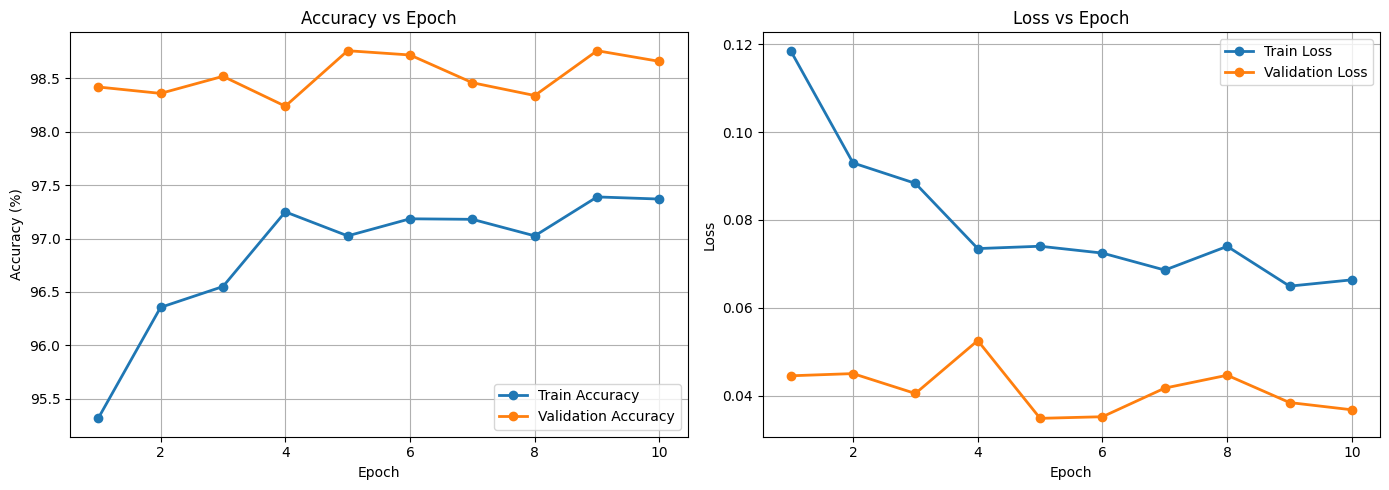

In [81]:
epochs = range(1, len(train_accs) + 1)#creates epoch numbers

plt.figure(figsize=(14, 5))#canvas for both graphs

#Accuracy vs Epoch
plt.subplot(1, 2, 1)#define grid (row,column,order)
plt.plot(epochs, train_accs, marker='o', linewidth=2,label="Train Accuracy")
plt.plot(epochs, val_accs, marker='o', linewidth=2,label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)

#Loss vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, marker='o', linewidth=2,label="Train Loss")
plt.plot(epochs, val_losses, marker='o', linewidth=2,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
